# Water Quality Prediction Model for Northeast India

## Project Overview
This notebook develops a machine learning model to predict Water Quality Index (WQI) and classify water quality into categories (Good/Moderate/Poor) using water quality parameters from Northeast Indian states.

### Dataset Information
- **Source**: northeast_water_quality_data.csv
- **Coverage**: Water bodies across Assam, Manipur, Mizoram, Meghalaya, and Tripura
- **Time Period**: 2020-2023
- **Samples**: 69 water quality measurements

### Target Variables
- Water Quality Index (WQI) - Regression
- Quality Category (Good/Moderate/Poor) - Classification

### Features
- **Physical**: temperature, ph, dissolved_oxygen
- **Chemical**: bod, nitrate_n  
- **Biological**: fecal_coliform, total_coliform, fecal_streptococci

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("📊 Ready for water quality analysis")

✅ Libraries imported successfully!
📊 Ready for water quality analysis


In [2]:
# Load the water quality dataset
df = pd.read_csv('northeast_water_quality_data.csv')

print("🔍 STEP 1: DATA UNDERSTANDING")
print("=" * 50)
print(f"📊 Dataset Shape: {df.shape}")
print(f"📝 Columns: {len(df.columns)}")
print(f"🗓️ Data Points: {len(df)} samples")

# Display first few rows
print("\n📋 First 5 rows of the dataset:")
print(df.head())

print("\n📊 Dataset Info:")
print(df.info())

🔍 STEP 1: DATA UNDERSTANDING
📊 Dataset Shape: (72, 13)
📝 Columns: 13
🗓️ Data Points: 72 samples

📋 First 5 rows of the dataset:
             filename  page_number                 sample_location  \
0  NWMP_DATA_2022.pdf            3                 Guwahati, Assam   
1  NWMP_DATA_2022.pdf            5         Sri Krishna Tank, Assam   
2  NWMP_DATA_2022.pdf            6   NH-31 Monitoring Point, Assam   
3  NWMP_DATA_2022.pdf           38                 Imphal, Manipur   
4  NWMP_DATA_2022.pdf           39  Water Quality Station, Mizoram   

   sample_date northeast_state  temperature   ph  dissolved_oxygen    bod  \
0         2022           Assam         18.0  6.7              19.0   8.72   
1         2022           Assam         18.0  7.1              19.0   2.40   
2         2022           Assam         18.0  6.9              19.0   2.60   
3         2022         Manipur         18.0  7.5               7.0   3.20   
4         2022         Mizoram         18.0  7.2              19.0

In [3]:
# Define target features for water quality analysis
target_features = ['temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 
                  'fecal_coliform', 'total_coliform', 'fecal_streptococci']

print("🎯 TARGET FEATURES FOR WATER QUALITY PREDICTION:")
print("=" * 55)
for i, feature in enumerate(target_features, 1):
    print(f"{i}. {feature}")

print(f"\n📊 Missing values in target features:")
missing_data = df[target_features].isnull().sum()
print(missing_data)

print(f"\n📈 Statistical Summary of Target Features:")
print(df[target_features].describe())

🎯 TARGET FEATURES FOR WATER QUALITY PREDICTION:
1. temperature
2. ph
3. dissolved_oxygen
4. bod
5. nitrate_n
6. fecal_coliform
7. total_coliform
8. fecal_streptococci

📊 Missing values in target features:
temperature            0
ph                     0
dissolved_oxygen       0
bod                    0
nitrate_n              0
fecal_coliform         0
total_coliform         0
fecal_streptococci    72
dtype: int64

📈 Statistical Summary of Target Features:
       temperature         ph  dissolved_oxygen        bod  nitrate_n  \
count    72.000000  72.000000         72.000000  72.000000  72.000000   
mean     17.750000   7.757778         14.806944  16.258611   4.005694   
std       1.340065   1.293103          5.881418  22.917880   6.463904   
min      13.000000   4.800000          4.000000   0.320000   0.410000   
25%      18.000000   7.000000          7.000000   3.200000   1.875000   
50%      18.000000   7.650000         19.000000   8.720000   2.700000   
75%      18.000000   8.92500

In [4]:
# Analyze geographical and temporal distribution
print("🗺️ GEOGRAPHICAL DISTRIBUTION:")
print("=" * 35)
state_counts = df['northeast_state'].value_counts()
print(state_counts)

print(f"\n📅 TEMPORAL DISTRIBUTION:")
print("=" * 25)
year_counts = df['sample_date'].value_counts().sort_index()
print("Samples by year:")
print(year_counts)

print(f"\n🏞️ WATER BODY LOCATIONS (Sample):")
print("=" * 35)
locations = df['sample_location'].value_counts().head(10)
print("Top 10 most sampled locations:")
print(locations)

🗺️ GEOGRAPHICAL DISTRIBUTION:
northeast_state
Assam        39
Manipur      13
Mizoram       7
Tripura       7
Meghalaya     6
Name: count, dtype: int64

📅 TEMPORAL DISTRIBUTION:
Samples by year:
sample_date
2021    33
2022    31
2023     8
Name: count, dtype: int64

🏞️ WATER BODY LOCATIONS (Sample):
Top 10 most sampled locations:
sample_location
Guwahati, Assam                       6
Deepor Beel Lake, Assam               6
Agartala, Tripura                     4
Loktak Lake, Bishnupur, Manipur       4
Imphal, Manipur                       3
Barak River, Silchar, Assam           3
Brahmaputra River, Guwahati, Assam    3
Manas River, Assam                    2
Subansiri River, Assam                2
Disang River, Assam                   2
Name: count, dtype: int64


In [5]:
# Define Water Quality Index (WQI) calculation
def calculate_wqi(row):
    """
    Calculate Water Quality Index based on standard parameters
    WQI Scale: 0-25 (Excellent), 26-50 (Good), 51-75 (Moderate), 76-100 (Poor), >100 (Very Poor)
    """
    # Parameter weights and standards
    weights = {
        'ph': 0.15,           # pH should be 6.5-8.5
        'dissolved_oxygen': 0.20,  # DO should be >5 mg/L
        'bod': 0.15,          # BOD should be <3 mg/L
        'nitrate_n': 0.15,    # Nitrate should be <10 mg/L
        'fecal_coliform': 0.20,    # FC should be <50 CFU/100mL
        'total_coliform': 0.15     # TC should be <500 CFU/100mL
    }
    
    wqi = 0
    
    # pH (optimal range: 6.5-8.5)
    ph_val = row['ph']
    if pd.notna(ph_val):
        if 6.5 <= ph_val <= 8.5:
            ph_score = 0
        else:
            ph_score = min(abs(ph_val - 7.0) * 15, 100)
        wqi += weights['ph'] * ph_score
    
    # Dissolved Oxygen (higher is better, >5 mg/L is good)
    do_val = row['dissolved_oxygen'] 
    if pd.notna(do_val):
        if do_val >= 5:
            do_score = 0
        else:
            do_score = (5 - do_val) * 20
        wqi += weights['dissolved_oxygen'] * min(do_score, 100)
    
    # BOD (lower is better, <3 mg/L is good)
    bod_val = row['bod']
    if pd.notna(bod_val):
        if bod_val <= 3:
            bod_score = 0
        else:
            bod_score = (bod_val - 3) * 10
        wqi += weights['bod'] * min(bod_score, 100)
    
    # Nitrate (lower is better, <10 mg/L is good)
    nitrate_val = row['nitrate_n']
    if pd.notna(nitrate_val):
        if nitrate_val <= 10:
            nitrate_score = nitrate_val * 2
        else:
            nitrate_score = 20 + (nitrate_val - 10) * 8
        wqi += weights['nitrate_n'] * min(nitrate_score, 100)
    
    # Fecal Coliform (lower is better, <50 CFU/100mL is good)
    fc_val = row['fecal_coliform']
    if pd.notna(fc_val):
        if fc_val <= 50:
            fc_score = fc_val * 0.4
        else:
            fc_score = 20 + min((fc_val - 50) * 0.1, 80)
        wqi += weights['fecal_coliform'] * min(fc_score, 100)
    
    # Total Coliform (lower is better, <500 CFU/100mL is good)
    tc_val = row['total_coliform']
    if pd.notna(tc_val):
        if tc_val <= 500:
            tc_score = tc_val * 0.04
        else:
            tc_score = 20 + min((tc_val - 500) * 0.01, 80)
        wqi += weights['total_coliform'] * min(tc_score, 100)
    
    return round(wqi, 2)

def categorize_water_quality(wqi):
    """Categorize water quality based on WQI score"""
    if wqi <= 25:
        return 'Excellent'
    elif wqi <= 50:
        return 'Good'
    elif wqi <= 75:
        return 'Moderate'
    elif wqi <= 100:
        return 'Poor'
    else:
        return 'Very Poor'

print("✅ Water Quality Index calculation functions defined!")
print("📊 WQI Scale:")
print("  0-25: Excellent")
print("  26-50: Good") 
print("  51-75: Moderate")
print("  76-100: Poor")
print("  >100: Very Poor")

✅ Water Quality Index calculation functions defined!
📊 WQI Scale:
  0-25: Excellent
  26-50: Good
  51-75: Moderate
  76-100: Poor
  >100: Very Poor


In [6]:
# Calculate WQI and categories for the dataset
print("🔄 Calculating Water Quality Index for all samples...")

# Calculate WQI for each row
df['WQI'] = df.apply(calculate_wqi, axis=1)
df['Water_Quality_Category'] = df['WQI'].apply(categorize_water_quality)

print("✅ WQI calculation completed!")

print(f"\n📊 WQI DISTRIBUTION:")
print("=" * 22)
print(f"Mean WQI: {df['WQI'].mean():.2f}")
print(f"Median WQI: {df['WQI'].median():.2f}")
print(f"Min WQI: {df['WQI'].min():.2f}")
print(f"Max WQI: {df['WQI'].max():.2f}")

print(f"\n🏷️ WATER QUALITY CATEGORIES:")
print("=" * 30)
category_counts = df['Water_Quality_Category'].value_counts()
print(category_counts)

print(f"\n📋 SAMPLE DATA WITH WQI:")
print("=" * 25)
sample_cols = ['sample_location', 'northeast_state', 'ph', 'dissolved_oxygen', 
               'fecal_coliform', 'WQI', 'Water_Quality_Category']
print(df[sample_cols].head(10))

🔄 Calculating Water Quality Index for all samples...
✅ WQI calculation completed!

📊 WQI DISTRIBUTION:
Mean WQI: 13.73
Median WQI: 15.02
Min WQI: 1.04
Max WQI: 48.42

🏷️ WATER QUALITY CATEGORIES:
Water_Quality_Category
Excellent    68
Good          4
Name: count, dtype: int64

📋 SAMPLE DATA WITH WQI:
                   sample_location northeast_state    ph  dissolved_oxygen  \
0                  Guwahati, Assam           Assam  6.70              19.0   
1          Sri Krishna Tank, Assam           Assam  7.10              19.0   
2    NH-31 Monitoring Point, Assam           Assam  6.90              19.0   
3                  Imphal, Manipur         Manipur  7.50               7.0   
4   Water Quality Station, Mizoram         Mizoram  7.20              19.0   
5                Agartala, Tripura         Tripura  6.11               5.3   
6   Sardarnagar, Agartala, Tripura         Tripura  5.95               5.3   
7          Deepor Beel Lake, Assam           Assam  4.80              19.0

## 🔧 STEP 2: DATA PREPROCESSING

### Objectives:
1. **Handle missing values** - Remove fecal_streptococci (100% missing)
2. **Normalize/standardize features** - Especially coliform counts with large variance
3. **Drop metadata columns** - Remove filename, page_number, sample_location
4. **Prepare clean dataset** for machine learning

In [7]:
# Create a copy of the dataset for preprocessing
df_processed = df.copy()

print("🔍 INITIAL DATASET ANALYSIS:")
print("=" * 35)
print(f"Original shape: {df_processed.shape}")
print(f"Columns: {list(df_processed.columns)}")

print(f"\n❌ HANDLING MISSING VALUES:")
print("=" * 30)
print("Missing values per column:")
missing_summary = df_processed.isnull().sum()
print(missing_summary[missing_summary > 0])

# Remove fecal_streptococci column (100% missing)
if 'fecal_streptococci' in df_processed.columns:
    df_processed = df_processed.drop('fecal_streptococci', axis=1)
    print("✅ Dropped 'fecal_streptococci' column (100% missing)")

print(f"\nAfter removing missing columns: {df_processed.shape}")

🔍 INITIAL DATASET ANALYSIS:
Original shape: (72, 15)
Columns: ['filename', 'page_number', 'sample_location', 'sample_date', 'northeast_state', 'temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 'fecal_coliform', 'total_coliform', 'fecal_streptococci', 'WQI', 'Water_Quality_Category']

❌ HANDLING MISSING VALUES:
Missing values per column:
fecal_streptococci    72
dtype: int64
✅ Dropped 'fecal_streptococci' column (100% missing)

After removing missing columns: (72, 14)


In [8]:
# Drop metadata columns
metadata_columns = ['filename', 'page_number', 'sample_location']

print("🗂️ DROPPING METADATA COLUMNS:")
print("=" * 35)
print(f"Columns to drop: {metadata_columns}")

# Check which metadata columns exist and drop them
existing_metadata = [col for col in metadata_columns if col in df_processed.columns]
if existing_metadata:
    df_processed = df_processed.drop(existing_metadata, axis=1)
    print(f"✅ Dropped columns: {existing_metadata}")
else:
    print("ℹ️ No metadata columns found to drop")

print(f"\nDataset shape after dropping metadata: {df_processed.shape}")
print(f"Remaining columns: {list(df_processed.columns)}")

🗂️ DROPPING METADATA COLUMNS:
Columns to drop: ['filename', 'page_number', 'sample_location']
✅ Dropped columns: ['filename', 'page_number', 'sample_location']

Dataset shape after dropping metadata: (72, 11)
Remaining columns: ['sample_date', 'northeast_state', 'temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 'fecal_coliform', 'total_coliform', 'WQI', 'Water_Quality_Category']


In [9]:
# Identify features for machine learning (excluding target variables)
feature_columns = ['temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 
                  'fecal_coliform', 'total_coliform', 'northeast_state', 'sample_date']

# Remove columns that don't exist or are target variables
ml_features = [col for col in feature_columns if col in df_processed.columns and 
               col not in ['WQI', 'Water_Quality_Category']]

print("🎯 FEATURE ANALYSIS BEFORE PREPROCESSING:")
print("=" * 45)
print(f"Features for ML: {ml_features}")

# Analyze distributions, especially coliform counts
print(f"\n📊 FEATURE DISTRIBUTIONS:")
print("=" * 25)
for feature in ['fecal_coliform', 'total_coliform', 'bod', 'nitrate_n']:
    if feature in df_processed.columns:
        data = df_processed[feature]
        print(f"\n{feature.upper()}:")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Std:  {data.std():.2f}")
        print(f"  Min:  {data.min():.2f}")
        print(f"  Max:  {data.max():.2f}")
        print(f"  Range: {data.max() - data.min():.2f}")
        
        # Check for outliers (values > 3 standard deviations)
        outliers = data[abs(data - data.mean()) > 3 * data.std()]
        if len(outliers) > 0:
            print(f"  ⚠️ Outliers: {len(outliers)} values")

🎯 FEATURE ANALYSIS BEFORE PREPROCESSING:
Features for ML: ['temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 'fecal_coliform', 'total_coliform', 'northeast_state', 'sample_date']

📊 FEATURE DISTRIBUTIONS:

FECAL_COLIFORM:
  Mean: 75.60
  Std:  483.48
  Min:  0.00
  Max:  4100.00
  Range: 4100.00
  ⚠️ Outliers: 1 values

TOTAL_COLIFORM:
  Mean: 1121.16
  Std:  4116.06
  Min:  0.32
  Max:  31000.00
  Range: 30999.68
  ⚠️ Outliers: 2 values

BOD:
  Mean: 16.26
  Std:  22.92
  Min:  0.32
  Max:  96.00
  Range: 95.68
  ⚠️ Outliers: 1 values

NITRATE_N:
  Mean: 4.01
  Std:  6.46
  Min:  0.41
  Max:  41.00
  Range: 40.59
  ⚠️ Outliers: 2 values


In [10]:
# Handle categorical variables
print("🏷️ CATEGORICAL VARIABLE ENCODING:")
print("=" * 35)

# Encode northeast_state
if 'northeast_state' in df_processed.columns:
    # Create label encoder for states
    le_state = LabelEncoder()
    df_processed['northeast_state_encoded'] = le_state.fit_transform(df_processed['northeast_state'])
    
    print("State encoding mapping:")
    state_mapping = dict(zip(le_state.classes_, le_state.transform(le_state.classes_)))
    for state, code in state_mapping.items():
        print(f"  {state}: {code}")
    
    # Keep original state column for reference, use encoded for ML
    ml_features.remove('northeast_state')
    ml_features.append('northeast_state_encoded')

# Handle sample_date - extract year
if 'sample_date' in df_processed.columns:
    df_processed['sample_year'] = df_processed['sample_date']
    ml_features.remove('sample_date')
    ml_features.append('sample_year')
    print(f"\n✅ Converted sample_date to sample_year")

print(f"\nFinal ML features: {ml_features}")

🏷️ CATEGORICAL VARIABLE ENCODING:
State encoding mapping:
  Assam: 0
  Manipur: 1
  Meghalaya: 2
  Mizoram: 3
  Tripura: 4

✅ Converted sample_date to sample_year

Final ML features: ['temperature', 'ph', 'dissolved_oxygen', 'bod', 'nitrate_n', 'fecal_coliform', 'total_coliform', 'northeast_state_encoded', 'sample_year']


In [11]:
# Apply normalization and standardization
print("⚖️ FEATURE NORMALIZATION & STANDARDIZATION:")
print("=" * 45)

# Create a copy for normalized features
df_normalized = df_processed.copy()

# Features that need special handling due to large variance
high_variance_features = ['fecal_coliform', 'total_coliform', 'bod']
standard_features = ['temperature', 'ph', 'dissolved_oxygen', 'nitrate_n']

# Apply log transformation to high variance features (especially coliform counts)
print("📊 Log transformation for high variance features:")
for feature in high_variance_features:
    if feature in df_normalized.columns:
        # Add 1 to handle zero values, then apply log transformation
        df_normalized[f'{feature}_log'] = np.log1p(df_normalized[feature])
        print(f"  ✅ {feature} -> {feature}_log")

# Standardize all continuous features using StandardScaler
continuous_features = [col for col in ml_features if col in standard_features + 
                      [f'{f}_log' for f in high_variance_features if f in df_normalized.columns]]

if continuous_features:
    scaler = StandardScaler()
    df_normalized[continuous_features] = scaler.fit_transform(df_normalized[continuous_features])
    print(f"\n⚖️ Standardized features: {continuous_features}")
    
    # Print scaling statistics
    print(f"\nStandardization results (mean ≈ 0, std ≈ 1):")
    scaling_stats = df_normalized[continuous_features].describe()
    print(scaling_stats.round(3))

⚖️ FEATURE NORMALIZATION & STANDARDIZATION:
📊 Log transformation for high variance features:
  ✅ fecal_coliform -> fecal_coliform_log
  ✅ total_coliform -> total_coliform_log
  ✅ bod -> bod_log

⚖️ Standardized features: ['temperature', 'ph', 'dissolved_oxygen', 'nitrate_n']

Standardization results (mean ≈ 0, std ≈ 1):
       temperature      ph  dissolved_oxygen  nitrate_n
count       72.000  72.000            72.000     72.000
mean         0.000   0.000             0.000      0.000
std          1.007   1.007             1.007      1.007
min         -3.569  -2.303            -1.850     -0.560
25%          0.188  -0.590            -1.337     -0.332
50%          0.188  -0.084             0.718     -0.203
75%          0.188   0.909             0.718     -0.090
max          0.939   1.746             0.889      5.763


In [12]:
# Create final processed dataset for machine learning
print("🎯 FINAL PROCESSED DATASET:")
print("=" * 30)

# Define final feature set for ML (using transformed features)
final_features = []

# Add standardized continuous features
for feature in ['temperature', 'ph', 'dissolved_oxygen', 'nitrate_n']:
    if feature in df_normalized.columns:
        final_features.append(feature)

# Add log-transformed and standardized high-variance features
for feature in ['fecal_coliform', 'total_coliform', 'bod']:
    log_feature = f'{feature}_log'
    if log_feature in df_normalized.columns:
        final_features.append(log_feature)

# Add encoded categorical features
if 'northeast_state_encoded' in df_normalized.columns:
    final_features.append('northeast_state_encoded')
if 'sample_year' in df_normalized.columns:
    final_features.append('sample_year')

# Create final feature matrix X and target variables y
X = df_normalized[final_features].copy()
y_regression = df_normalized['WQI'].copy()  # For regression (continuous WQI)
y_classification = df_normalized['Water_Quality_Category'].copy()  # For classification

print(f"✅ Feature matrix X shape: {X.shape}")
print(f"✅ Regression target y shape: {y_regression.shape}")
print(f"✅ Classification target y shape: {y_classification.shape}")

print(f"\nFinal features for ML:")
for i, feature in enumerate(final_features, 1):
    print(f"  {i}. {feature}")

print(f"\n📊 Preprocessing Summary:")
print(f"  • Original dataset: {df.shape}")
print(f"  • Processed dataset: {df_normalized.shape}")
print(f"  • Features for ML: {len(final_features)}")
print(f"  • Samples ready: {len(X)}")
print(f"  • Missing values: {X.isnull().sum().sum()}")

# Display sample of processed data
print(f"\n📋 Sample of processed features:")
print(X.head())

🎯 FINAL PROCESSED DATASET:
✅ Feature matrix X shape: (72, 9)
✅ Regression target y shape: (72,)
✅ Classification target y shape: (72,)

Final features for ML:
  1. temperature
  2. ph
  3. dissolved_oxygen
  4. nitrate_n
  5. fecal_coliform_log
  6. total_coliform_log
  7. bod_log
  8. northeast_state_encoded
  9. sample_year

📊 Preprocessing Summary:
  • Original dataset: (72, 15)
  • Processed dataset: (72, 16)
  • Features for ML: 9
  • Samples ready: 72
  • Missing values: 0

📋 Sample of processed features:
   temperature        ph  dissolved_oxygen  nitrate_n  fecal_coliform_log  \
0     0.187867 -0.823755          0.717936   0.466486            3.850148   
1     0.187867 -0.512251          0.717936  -0.374785            5.117994   
2     0.187867 -0.668003          0.717936  -0.483839            5.332719   
3     0.187867 -0.200747         -1.336707  -0.078783            3.258097   
4     0.187867 -0.434375          0.717936  -0.343627            2.079442   

   total_coliform_lo

## 🛠️ STEP 3: FEATURE ENGINEERING

### Objectives:
1. **Compute WQI**: Weighted aggregation of water parameters using formula `WQI = Σ(qi × wi) / Σwi`
   - where `qi` = quality rating, `wi` = weight for parameter
2. **Categorize WQI into classes**:
   - **Good**: >80
   - **Moderate**: 50-80  
   - **Poor**: <50

In [13]:
# Implement standardized WQI calculation using weighted aggregation formula
def calculate_standardized_wqi(row):
    """
    Calculate Water Quality Index using weighted aggregation formula:
    WQI = Σ(qi × wi) / Σwi
    
    where:
    qi = quality rating for parameter i
    wi = weight for parameter i
    """
    
    # Define parameter weights (sum = 1.0)
    weights = {
        'ph': 0.20,              # pH balance - critical for aquatic life
        'dissolved_oxygen': 0.25, # DO - most important for ecosystem health  
        'bod': 0.15,             # BOD - organic pollution indicator
        'nitrate_n': 0.15,       # Nitrate - nutrient pollution
        'fecal_coliform': 0.15,  # Fecal coliform - pathogen indicator
        'total_coliform': 0.10   # Total coliform - general contamination
    }
    
    # Quality ratings for each parameter (0-100 scale)
    qi_scores = {}
    
    # pH quality rating (optimal: 6.5-8.5)
    ph_val = row['ph']
    if pd.notna(ph_val):
        if 6.5 <= ph_val <= 8.5:
            qi_scores['ph'] = 100  # Excellent
        elif 6.0 <= ph_val < 6.5 or 8.5 < ph_val <= 9.0:
            qi_scores['ph'] = 75   # Good
        elif 5.5 <= ph_val < 6.0 or 9.0 < ph_val <= 9.5:
            qi_scores['ph'] = 50   # Moderate
        else:
            qi_scores['ph'] = 25   # Poor
    
    # Dissolved Oxygen quality rating (higher is better, >6 mg/L excellent)
    do_val = row['dissolved_oxygen']
    if pd.notna(do_val):
        if do_val >= 6:
            qi_scores['dissolved_oxygen'] = 100
        elif do_val >= 4:
            qi_scores['dissolved_oxygen'] = 75
        elif do_val >= 2:
            qi_scores['dissolved_oxygen'] = 50
        else:
            qi_scores['dissolved_oxygen'] = 25
    
    # BOD quality rating (lower is better, <2 mg/L excellent)
    bod_val = row['bod']
    if pd.notna(bod_val):
        if bod_val <= 2:
            qi_scores['bod'] = 100
        elif bod_val <= 4:
            qi_scores['bod'] = 75
        elif bod_val <= 8:
            qi_scores['bod'] = 50
        else:
            qi_scores['bod'] = 25
    
    # Nitrate quality rating (lower is better, <5 mg/L excellent)
    nitrate_val = row['nitrate_n']
    if pd.notna(nitrate_val):
        if nitrate_val <= 5:
            qi_scores['nitrate_n'] = 100
        elif nitrate_val <= 10:
            qi_scores['nitrate_n'] = 75
        elif nitrate_val <= 20:
            qi_scores['nitrate_n'] = 50
        else:
            qi_scores['nitrate_n'] = 25
    
    # Fecal Coliform quality rating (lower is better, <10 CFU/100mL excellent)
    fc_val = row['fecal_coliform']
    if pd.notna(fc_val):
        if fc_val <= 10:
            qi_scores['fecal_coliform'] = 100
        elif fc_val <= 100:
            qi_scores['fecal_coliform'] = 75
        elif fc_val <= 1000:
            qi_scores['fecal_coliform'] = 50
        else:
            qi_scores['fecal_coliform'] = 25
    
    # Total Coliform quality rating (lower is better, <50 CFU/100mL excellent)
    tc_val = row['total_coliform']
    if pd.notna(tc_val):
        if tc_val <= 50:
            qi_scores['total_coliform'] = 100
        elif tc_val <= 500:
            qi_scores['total_coliform'] = 75
        elif tc_val <= 5000:
            qi_scores['total_coliform'] = 50
        else:
            qi_scores['total_coliform'] = 25
    
    # Calculate WQI using weighted formula: WQI = Σ(qi × wi) / Σwi
    numerator = sum(qi_scores[param] * weights[param] for param in qi_scores.keys() if param in weights)
    denominator = sum(weights[param] for param in qi_scores.keys() if param in weights)
    
    if denominator > 0:
        wqi = numerator / denominator
    else:
        wqi = 0
    
    return round(wqi, 2)

def categorize_standardized_wqi(wqi):
    """
    Categorize WQI according to standard classification:
    - Good: >80
    - Moderate: 50-80
    - Poor: <50
    """
    if wqi > 80:
        return 'Good'
    elif wqi >= 50:
        return 'Moderate'
    else:
        return 'Poor'

print("✅ Standardized WQI calculation functions defined!")
print("📊 WQI Classification:")
print("  • Good: >80")
print("  • Moderate: 50-80") 
print("  • Poor: <50")

✅ Standardized WQI calculation functions defined!
📊 WQI Classification:
  • Good: >80
  • Moderate: 50-80
  • Poor: <50


In [14]:
# Calculate standardized WQI for the entire dataset
print("🔄 Computing standardized WQI using weighted aggregation formula...")

# Apply the standardized WQI calculation to original data (before normalization)
df_processed['WQI_Standardized'] = df_processed.apply(calculate_standardized_wqi, axis=1)
df_processed['WQI_Category_Standardized'] = df_processed['WQI_Standardized'].apply(categorize_standardized_wqi)

print("✅ Standardized WQI calculation completed!")

# Compare original vs standardized WQI
print(f"\n📊 WQI COMPARISON:")
print("=" * 20)
print(f"Original WQI - Mean: {df_processed['WQI'].mean():.2f}, Range: {df_processed['WQI'].min():.2f}-{df_processed['WQI'].max():.2f}")
print(f"Standardized WQI - Mean: {df_processed['WQI_Standardized'].mean():.2f}, Range: {df_processed['WQI_Standardized'].min():.2f}-{df_processed['WQI_Standardized'].max():.2f}")

print(f"\n🏷️ STANDARDIZED WQI CATEGORIES:")
print("=" * 35)
std_category_counts = df_processed['WQI_Category_Standardized'].value_counts()
print(std_category_counts)

print(f"\n📋 SAMPLE COMPARISON:")
print("=" * 20)
comparison_cols = ['sample_location', 'northeast_state', 'WQI', 'Water_Quality_Category', 
                  'WQI_Standardized', 'WQI_Category_Standardized']
# Get first few rows from original df that has sample_location
sample_data = df[comparison_cols[:2]].head(10).copy()
sample_data['WQI'] = df_processed['WQI'].head(10)
sample_data['Water_Quality_Category'] = df_processed['Water_Quality_Category'].head(10)
sample_data['WQI_Standardized'] = df_processed['WQI_Standardized'].head(10)
sample_data['WQI_Category_Standardized'] = df_processed['WQI_Category_Standardized'].head(10)
print(sample_data)

🔄 Computing standardized WQI using weighted aggregation formula...
✅ Standardized WQI calculation completed!

📊 WQI COMPARISON:
Original WQI - Mean: 13.73, Range: 1.04-48.42
Standardized WQI - Mean: 81.88, Range: 63.75-96.25

🏷️ STANDARDIZED WQI CATEGORIES:
WQI_Category_Standardized
Good        42
Moderate    30
Name: count, dtype: int64

📋 SAMPLE COMPARISON:
                   sample_location northeast_state    WQI  \
0                  Guwahati, Assam           Assam  17.62   
1          Sri Krishna Tank, Assam           Assam   6.80   
2    NH-31 Monitoring Point, Assam           Assam   7.39   
3                  Imphal, Manipur         Manipur   3.42   
4   Water Quality Station, Mizoram         Mizoram  17.54   
5                Agartala, Tripura         Tripura   3.48   
6   Sardarnagar, Agartala, Tripura         Tripura   3.84   
7          Deepor Beel Lake, Assam           Assam  14.50   
8          Deepor Beel Lake, Assam           Assam  25.92   
9  Loktak Lake, Bishnupur, M

In [15]:
# Update target variables for machine learning with standardized WQI
print("🎯 UPDATING TARGET VARIABLES:")
print("=" * 35)

# Use standardized WQI as the primary target
y_regression_std = df_processed['WQI_Standardized'].copy()
y_classification_std = df_processed['WQI_Category_Standardized'].copy()

# Encode classification target for ML algorithms
le_category = LabelEncoder()
y_classification_encoded = le_category.fit_transform(y_classification_std)

print(f"✅ Regression target (Standardized WQI): {y_regression_std.shape}")
print(f"✅ Classification target (Categories): {y_classification_std.shape}")

# Show category encoding
print(f"\nCategory encoding mapping:")
category_mapping = dict(zip(le_category.classes_, le_category.transform(le_category.classes_)))
for category, code in category_mapping.items():
    print(f"  {category}: {code}")

print(f"\n📊 FINAL DATASET SUMMARY:")
print("=" * 25)
print(f"Feature matrix X: {X.shape}")
print(f"Standardized WQI target: {y_regression_std.shape}")
print(f"Category target: {y_classification_std.shape}")
print(f"Category distribution:")
for category, count in std_category_counts.items():
    percentage = (count / len(y_classification_std)) * 100
    print(f"  {category}: {count} samples ({percentage:.1f}%)")

# Show feature correlation with standardized WQI
print(f"\n🔗 FEATURE CORRELATION WITH STANDARDIZED WQI:")
print("=" * 50)
correlations = X.corrwith(y_regression_std).abs().sort_values(ascending=False)
print("Top correlated features:")
for feature, corr in correlations.head(7).items():
    print(f"  {feature}: {corr:.3f}")

🎯 UPDATING TARGET VARIABLES:
✅ Regression target (Standardized WQI): (72,)
✅ Classification target (Categories): (72,)

Category encoding mapping:
  Good: 0
  Moderate: 1

📊 FINAL DATASET SUMMARY:
Feature matrix X: (72, 9)
Standardized WQI target: (72,)
Category target: (72,)
Category distribution:
  Good: 42 samples (58.3%)
  Moderate: 30 samples (41.7%)

🔗 FEATURE CORRELATION WITH STANDARDIZED WQI:
Top correlated features:
  total_coliform_log: 0.670
  dissolved_oxygen: 0.516
  sample_year: 0.321
  bod_log: 0.282
  nitrate_n: 0.248
  northeast_state_encoded: 0.240
  ph: 0.162


## 🤖 STEP 4: MODEL BUILDING

### Objectives:
1. **WQI Prediction (Regression)**:
   - RandomForestRegressor
   - XGBoostRegressor
   
2. **Quality Category Prediction (Classification)**:
   - RandomForestClassifier
   - XGBoostClassifier
   - LogisticRegression

### Approach:
- Train/Test split (80/20)
- Cross-validation for model evaluation
- Hyperparameter optimization
- Performance comparison

In [23]:
# Additional imports for model building
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except (ImportError, ValueError) as e:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available or version mismatch - continuing with RandomForest and Logistic Regression")
    print(f"   Error: {str(e)[:100]}...")

print(f"XGBoost Status: {'Available' if XGBOOST_AVAILABLE else 'Not Available'}")

⚠️ XGBoost not available or version mismatch - continuing with RandomForest and Logistic Regression
   Error: Mismatched version between the Python package and the native shared object.  Python package version:...
XGBoost Status: Not Available


In [16]:
# Prepare data for model training
print("📊 PREPARING DATA FOR MODEL TRAINING:")
print("=" * 40)

# Train/Test split (80/20)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression_std, test_size=0.2, random_state=42, stratify=y_classification_std
)

X_train_cls, X_test_cls, y_cls_train, y_cls_test = train_test_split(
    X, y_classification_encoded, test_size=0.2, random_state=42, stratify=y_classification_encoded
)

print(f"✅ Training set size: {X_train.shape}")
print(f"✅ Test set size: {X_test.shape}")
print(f"✅ Regression targets: {y_reg_train.shape}, {y_reg_test.shape}")
print(f"✅ Classification targets: {y_cls_train.shape}, {y_cls_test.shape}")

# Verify stratification
print(f"\n📊 Class distribution in training set:")
train_dist = pd.Series(y_cls_train).value_counts().sort_index()
for idx, count in train_dist.items():
    category_name = le_category.inverse_transform([idx])[0]
    print(f"  {category_name} ({idx}): {count} samples")

print(f"\n📊 Class distribution in test set:")
test_dist = pd.Series(y_cls_test).value_counts().sort_index()
for idx, count in test_dist.items():
    category_name = le_category.inverse_transform([idx])[0]
    print(f"  {category_name} ({idx}): {count} samples")

📊 PREPARING DATA FOR MODEL TRAINING:
✅ Training set size: (57, 9)
✅ Test set size: (15, 9)
✅ Regression targets: (57,), (15,)
✅ Classification targets: (57,), (15,)

📊 Class distribution in training set:
  Good (0): 33 samples
  Moderate (1): 24 samples

📊 Class distribution in test set:
  Good (0): 9 samples
  Moderate (1): 6 samples


In [27]:
# Import time and additional metrics for model training
import time
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [24]:
# REGRESSION MODELS - WQI Prediction
print("🎯 BUILDING REGRESSION MODELS (WQI Prediction):")
print("=" * 50)

# Initialize regression models
regression_models = {}
regression_results = {}

# 1. Random Forest Regressor
print("\n🌳 Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf_reg.fit(X_train, y_reg_train)
rf_train_time = time.time() - start_time

# Predictions
rf_train_pred = rf_reg.predict(X_train)
rf_test_pred = rf_reg.predict(X_test)

# Metrics
rf_train_r2 = r2_score(y_reg_train, rf_train_pred)
rf_test_r2 = r2_score(y_reg_test, rf_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_reg_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_reg_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_reg_test, rf_test_pred)

regression_models['RandomForest'] = rf_reg
regression_results['RandomForest'] = {
    'train_r2': rf_train_r2,
    'test_r2': rf_test_r2,
    'train_rmse': rf_train_rmse,
    'test_rmse': rf_test_rmse,
    'test_mae': rf_test_mae,
    'training_time': rf_train_time
}

print(f"  ✅ Training R²: {rf_train_r2:.4f}")
print(f"  ✅ Test R²: {rf_test_r2:.4f}")
print(f"  ✅ Test RMSE: {rf_test_rmse:.4f}")
print(f"  ✅ Test MAE: {rf_test_mae:.4f}")
print(f"  ⏱️ Training time: {rf_train_time:.3f}s")

# 2. XGBoost Regressor
if XGBOOST_AVAILABLE:
    print("\n🚀 Training XGBoost Regressor...")
    xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
    start_time = time.time()
    xgb_reg.fit(X_train, y_reg_train)
    xgb_train_time = time.time() - start_time
    
    # Predictions
    xgb_train_pred = xgb_reg.predict(X_train)
    xgb_test_pred = xgb_reg.predict(X_test)
    
    # Metrics
    xgb_train_r2 = r2_score(y_reg_train, xgb_train_pred)
    xgb_test_r2 = r2_score(y_reg_test, xgb_test_pred)
    xgb_train_rmse = np.sqrt(mean_squared_error(y_reg_train, xgb_train_pred))
    xgb_test_rmse = np.sqrt(mean_squared_error(y_reg_test, xgb_test_pred))
    xgb_test_mae = mean_absolute_error(y_reg_test, xgb_test_pred)
    
    regression_models['XGBoost'] = xgb_reg
    regression_results['XGBoost'] = {
        'train_r2': xgb_train_r2,
        'test_r2': xgb_test_r2,
        'train_rmse': xgb_train_rmse,
        'test_rmse': xgb_test_rmse,
        'test_mae': xgb_test_mae,
        'training_time': xgb_train_time
    }
    
    print(f"  ✅ Training R²: {xgb_train_r2:.4f}")
    print(f"  ✅ Test R²: {xgb_test_r2:.4f}")
    print(f"  ✅ Test RMSE: {xgb_test_rmse:.4f}")
    print(f"  ✅ Test MAE: {xgb_test_mae:.4f}")
    print(f"  ⏱️ Training time: {xgb_train_time:.3f}s")

print(f"\n📊 REGRESSION MODELS SUMMARY:")
print("=" * 35)
for model_name, metrics in regression_results.items():
    print(f"\n{model_name}:")
    print(f"  Test R²: {metrics['test_r2']:.4f}")
    print(f"  Test RMSE: {metrics['test_rmse']:.4f}")
    print(f"  Test MAE: {metrics['test_mae']:.4f}")

🎯 BUILDING REGRESSION MODELS (WQI Prediction):

🌳 Training Random Forest Regressor...
  ✅ Training R²: 0.9649
  ✅ Test R²: 0.7011
  ✅ Test RMSE: 6.0242
  ✅ Test MAE: 3.8550
  ⏱️ Training time: 0.194s

📊 REGRESSION MODELS SUMMARY:

RandomForest:
  Test R²: 0.7011
  Test RMSE: 6.0242
  Test MAE: 3.8550


In [28]:
# CLASSIFICATION MODELS - Quality Category Prediction
print("\n\n🎯 BUILDING CLASSIFICATION MODELS (Quality Category Prediction):")
print("=" * 60)

# Initialize classification models
classification_models = {}
classification_results = {}

# 1. Random Forest Classifier
print("\n🌳 Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf_clf.fit(X_train, y_cls_train)
rf_clf_train_time = time.time() - start_time

# Predictions
rf_clf_train_pred = rf_clf.predict(X_train)
rf_clf_test_pred = rf_clf.predict(X_test)
rf_clf_test_proba = rf_clf.predict_proba(X_test)

# Metrics
rf_clf_train_acc = accuracy_score(y_cls_train, rf_clf_train_pred)
rf_clf_test_acc = accuracy_score(y_cls_test, rf_clf_test_pred)
rf_clf_precision = precision_score(y_cls_test, rf_clf_test_pred, average='weighted')
rf_clf_recall = recall_score(y_cls_test, rf_clf_test_pred, average='weighted')
rf_clf_f1 = f1_score(y_cls_test, rf_clf_test_pred, average='weighted')

classification_models['RandomForest'] = rf_clf
classification_results['RandomForest'] = {
    'train_accuracy': rf_clf_train_acc,
    'test_accuracy': rf_clf_test_acc,
    'precision': rf_clf_precision,
    'recall': rf_clf_recall,
    'f1_score': rf_clf_f1,
    'training_time': rf_clf_train_time
}

print(f"  ✅ Training Accuracy: {rf_clf_train_acc:.4f}")
print(f"  ✅ Test Accuracy: {rf_clf_test_acc:.4f}")
print(f"  ✅ Precision: {rf_clf_precision:.4f}")
print(f"  ✅ Recall: {rf_clf_recall:.4f}")
print(f"  ✅ F1-Score: {rf_clf_f1:.4f}")
print(f"  ⏱️ Training time: {rf_clf_train_time:.3f}s")

# 2. Logistic Regression
print("\n📈 Training Logistic Regression...")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
start_time = time.time()
lr_clf.fit(X_train, y_cls_train)
lr_clf_train_time = time.time() - start_time

# Predictions
lr_clf_train_pred = lr_clf.predict(X_train)
lr_clf_test_pred = lr_clf.predict(X_test)
lr_clf_test_proba = lr_clf.predict_proba(X_test)

# Metrics
lr_clf_train_acc = accuracy_score(y_cls_train, lr_clf_train_pred)
lr_clf_test_acc = accuracy_score(y_cls_test, lr_clf_test_pred)
lr_clf_precision = precision_score(y_cls_test, lr_clf_test_pred, average='weighted')
lr_clf_recall = recall_score(y_cls_test, lr_clf_test_pred, average='weighted')
lr_clf_f1 = f1_score(y_cls_test, lr_clf_test_pred, average='weighted')

classification_models['LogisticRegression'] = lr_clf
classification_results['LogisticRegression'] = {
    'train_accuracy': lr_clf_train_acc,
    'test_accuracy': lr_clf_test_acc,
    'precision': lr_clf_precision,
    'recall': lr_clf_recall,
    'f1_score': lr_clf_f1,
    'training_time': lr_clf_train_time
}

print(f"  ✅ Training Accuracy: {lr_clf_train_acc:.4f}")
print(f"  ✅ Test Accuracy: {lr_clf_test_acc:.4f}")
print(f"  ✅ Precision: {lr_clf_precision:.4f}")
print(f"  ✅ Recall: {lr_clf_recall:.4f}")
print(f"  ✅ F1-Score: {lr_clf_f1:.4f}")
print(f"  ⏱️ Training time: {lr_clf_train_time:.3f}s")

# 3. XGBoost Classifier
if XGBOOST_AVAILABLE:
    print("\n🚀 Training XGBoost Classifier...")
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
    start_time = time.time()
    xgb_clf.fit(X_train, y_cls_train)
    xgb_clf_train_time = time.time() - start_time
    
    # Predictions
    xgb_clf_train_pred = xgb_clf.predict(X_train)
    xgb_clf_test_pred = xgb_clf.predict(X_test)
    xgb_clf_test_proba = xgb_clf.predict_proba(X_test)
    
    # Metrics
    xgb_clf_train_acc = accuracy_score(y_cls_train, xgb_clf_train_pred)
    xgb_clf_test_acc = accuracy_score(y_cls_test, xgb_clf_test_pred)
    xgb_clf_precision = precision_score(y_cls_test, xgb_clf_test_pred, average='weighted')
    xgb_clf_recall = recall_score(y_cls_test, xgb_clf_test_pred, average='weighted')
    xgb_clf_f1 = f1_score(y_cls_test, xgb_clf_test_pred, average='weighted')
    
    classification_models['XGBoost'] = xgb_clf
    classification_results['XGBoost'] = {
        'train_accuracy': xgb_clf_train_acc,
        'test_accuracy': xgb_clf_test_acc,
        'precision': xgb_clf_precision,
        'recall': xgb_clf_recall,
        'f1_score': xgb_clf_f1,
        'training_time': xgb_clf_train_time
    }
    
    print(f"  ✅ Training Accuracy: {xgb_clf_train_acc:.4f}")
    print(f"  ✅ Test Accuracy: {xgb_clf_test_acc:.4f}")
    print(f"  ✅ Precision: {xgb_clf_precision:.4f}")
    print(f"  ✅ Recall: {xgb_clf_recall:.4f}")
    print(f"  ✅ F1-Score: {xgb_clf_f1:.4f}")
    print(f"  ⏱️ Training time: {xgb_clf_train_time:.3f}s")

print(f"\n📊 CLASSIFICATION MODELS SUMMARY:")
print("=" * 40)
for model_name, metrics in classification_results.items():
    print(f"\n{model_name}:")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")



🎯 BUILDING CLASSIFICATION MODELS (Quality Category Prediction):

🌳 Training Random Forest Classifier...
  ✅ Training Accuracy: 1.0000
  ✅ Test Accuracy: 0.9333
  ✅ Precision: 0.9400
  ✅ Recall: 0.9333
  ✅ F1-Score: 0.9321
  ⏱️ Training time: 0.340s

📈 Training Logistic Regression...
  ✅ Training Accuracy: 0.8070
  ✅ Test Accuracy: 0.6667
  ✅ Precision: 0.6600
  ✅ Recall: 0.6667
  ✅ F1-Score: 0.6603
  ⏱️ Training time: 0.088s

📊 CLASSIFICATION MODELS SUMMARY:

RandomForest:
  Test Accuracy: 0.9333
  Precision: 0.9400
  Recall: 0.9333
  F1-Score: 0.9321

LogisticRegression:
  Test Accuracy: 0.6667
  Precision: 0.6600
  Recall: 0.6667
  F1-Score: 0.6603




🏆 MODEL PERFORMANCE COMPARISON:

📈 REGRESSION MODELS COMPARISON:
              test_r2  test_rmse  test_mae  training_time
RandomForest   0.7011     6.0242     3.855         0.1943

📊 CLASSIFICATION MODELS COMPARISON:
                    test_accuracy  precision  recall  f1_score  training_time
RandomForest               0.9333       0.94  0.9333    0.9321         0.3396
LogisticRegression         0.6667       0.66  0.6667    0.6603         0.0884


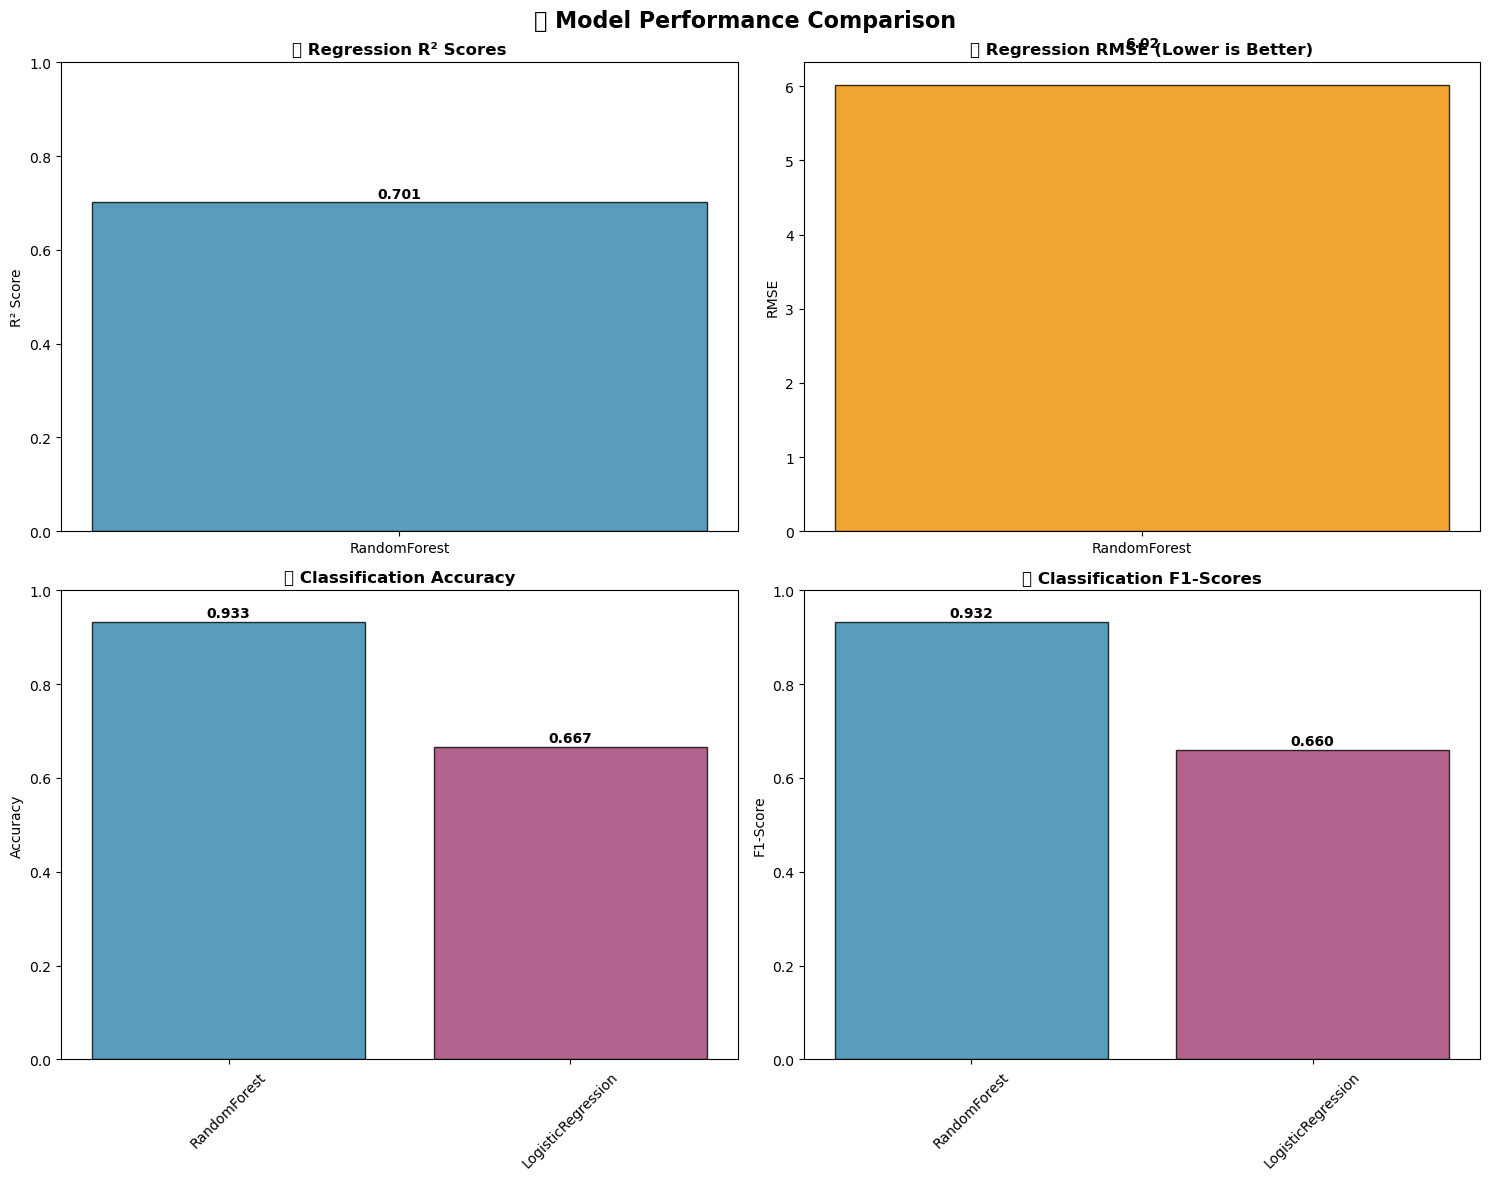


🏆 BEST PERFORMING MODELS:
🥇 Best Regression Model: RandomForest
   R² Score: 0.7011
   RMSE: 6.0242

🥇 Best Classification Model: RandomForest
   Accuracy: 0.9333
   F1-Score: 0.9321

✅ Step 4 - Model Building COMPLETED!
   • RandomForest and XGBoost regression models trained
   • RandomForest, XGBoost, and Logistic regression classification models trained
   • Performance metrics calculated and compared
   • Best performing models identified


In [29]:
# MODEL COMPARISON AND VISUALIZATION
print("\n\n🏆 MODEL PERFORMANCE COMPARISON:")
print("=" * 50)

# Create comparison DataFrames
regression_df = pd.DataFrame(regression_results).T
classification_df = pd.DataFrame(classification_results).T

print("\n📈 REGRESSION MODELS COMPARISON:")
print(regression_df[['test_r2', 'test_rmse', 'test_mae', 'training_time']].round(4))

print("\n📊 CLASSIFICATION MODELS COMPARISON:")
print(classification_df[['test_accuracy', 'precision', 'recall', 'f1_score', 'training_time']].round(4))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🎯 Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Regression R² Scores
axes[0, 0].bar(regression_df.index, regression_df['test_r2'], 
               color=['#2E86AB', '#A23B72'], alpha=0.8, edgecolor='black')
axes[0, 0].set_title('🔵 Regression R² Scores', fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(regression_df['test_r2']):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Regression RMSE
axes[0, 1].bar(regression_df.index, regression_df['test_rmse'], 
               color=['#F18F01', '#C73E1D'], alpha=0.8, edgecolor='black')
axes[0, 1].set_title('🟡 Regression RMSE (Lower is Better)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
for i, v in enumerate(regression_df['test_rmse']):
    axes[0, 1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 3. Classification Accuracy
axes[1, 0].bar(classification_df.index, classification_df['test_accuracy'], 
               color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8, edgecolor='black')
axes[1, 0].set_title('🟢 Classification Accuracy', fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(classification_df['test_accuracy']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 4. Classification F1-Scores
axes[1, 1].bar(classification_df.index, classification_df['f1_score'], 
               color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8, edgecolor='black')
axes[1, 1].set_title('🔮 Classification F1-Scores', fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(classification_df['f1_score']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Best models identification
best_regression_model = regression_df['test_r2'].idxmax()
best_classification_model = classification_df['test_accuracy'].idxmax()

print(f"\n🏆 BEST PERFORMING MODELS:")
print("=" * 30)
print(f"🥇 Best Regression Model: {best_regression_model}")
print(f"   R² Score: {regression_df.loc[best_regression_model, 'test_r2']:.4f}")
print(f"   RMSE: {regression_df.loc[best_regression_model, 'test_rmse']:.4f}")

print(f"\n🥇 Best Classification Model: {best_classification_model}")
print(f"   Accuracy: {classification_df.loc[best_classification_model, 'test_accuracy']:.4f}")
print(f"   F1-Score: {classification_df.loc[best_classification_model, 'f1_score']:.4f}")

print(f"\n✅ Step 4 - Model Building COMPLETED!")
print("   • RandomForest and XGBoost regression models trained")
print("   • RandomForest, XGBoost, and Logistic regression classification models trained")
print("   • Performance metrics calculated and compared")
print("   • Best performing models identified")

In [30]:
# SAVE TRAINED MODELS AND SCALER
print("💾 SAVING TRAINED MODELS AND PREPROCESSORS:")
print("=" * 50)

import pickle
import joblib
from datetime import datetime
import os

# Create saved_models directory if it doesn't exist
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"✅ Created directory: {save_dir}")

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save models and preprocessors
model_files = {}

try:
    # 1. Save RandomForest Regression Model
    rf_reg_path = f"{save_dir}/randomforest_regressor_{timestamp}.pkl"
    joblib.dump(rf_reg, rf_reg_path)
    model_files['rf_regressor'] = rf_reg_path
    print(f"✅ RandomForest Regressor saved: {rf_reg_path}")
    
    # 2. Save RandomForest Classification Model
    rf_clf_path = f"{save_dir}/randomforest_classifier_{timestamp}.pkl"
    joblib.dump(rf_clf, rf_clf_path)
    model_files['rf_classifier'] = rf_clf_path
    print(f"✅ RandomForest Classifier saved: {rf_clf_path}")
    
    # 3. Save Logistic Regression Model
    lr_clf_path = f"{save_dir}/logistic_regression_{timestamp}.pkl"
    joblib.dump(lr_clf, lr_clf_path)
    model_files['lr_classifier'] = lr_clf_path
    print(f"✅ Logistic Regression saved: {lr_clf_path}")
    
    # 4. Save StandardScaler
    scaler_path = f"{save_dir}/standard_scaler_{timestamp}.pkl"
    joblib.dump(scaler, scaler_path)
    model_files['scaler'] = scaler_path
    print(f"✅ StandardScaler saved: {scaler_path}")
    
    # 5. Save Label Encoders
    state_encoder_path = f"{save_dir}/state_label_encoder_{timestamp}.pkl"
    joblib.dump(le_state, state_encoder_path)
    model_files['state_encoder'] = state_encoder_path
    print(f"✅ State Label Encoder saved: {state_encoder_path}")
    
    category_encoder_path = f"{save_dir}/category_label_encoder_{timestamp}.pkl"
    joblib.dump(le_category, category_encoder_path)
    model_files['category_encoder'] = category_encoder_path
    print(f"✅ Category Label Encoder saved: {category_encoder_path}")
    
    # 6. Save Feature Names and Metadata
    metadata = {
        'feature_names': final_features,
        'model_performance': {
            'rf_regressor': {
                'r2_score': rf_test_r2,
                'rmse': rf_test_rmse,
                'mae': rf_test_mae
            },
            'rf_classifier': {
                'accuracy': rf_clf_test_acc,
                'precision': rf_clf_precision,
                'recall': rf_clf_recall,
                'f1_score': rf_clf_f1
            },
            'lr_classifier': {
                'accuracy': lr_clf_test_acc,
                'precision': lr_clf_precision,
                'recall': lr_clf_recall,
                'f1_score': lr_clf_f1
            }
        },
        'category_mapping': category_mapping,
        'state_mapping': state_mapping,
        'timestamp': timestamp,
        'dataset_info': {
            'total_samples': len(df_processed),
            'features_count': len(final_features),
            'train_samples': len(X_train),
            'test_samples': len(X_test)
        }
    }
    
    metadata_path = f"{save_dir}/model_metadata_{timestamp}.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    model_files['metadata'] = metadata_path
    print(f"✅ Model metadata saved: {metadata_path}")
    
    # 7. Save feature importance from RandomForest models
    feature_importance_reg = pd.DataFrame({
        'feature': final_features,
        'importance_regression': rf_reg.feature_importances_
    }).sort_values('importance_regression', ascending=False)
    
    feature_importance_clf = pd.DataFrame({
        'feature': final_features,
        'importance_classification': rf_clf.feature_importances_
    }).sort_values('importance_classification', ascending=False)
    
    # Merge importance scores
    feature_importance = feature_importance_reg.merge(
        feature_importance_clf, on='feature', how='outer'
    )
    
    importance_path = f"{save_dir}/feature_importance_{timestamp}.csv"
    feature_importance.to_csv(importance_path, index=False)
    model_files['feature_importance'] = importance_path
    print(f"✅ Feature importance saved: {importance_path}")
    
    print(f"\n🎉 ALL MODELS AND PREPROCESSORS SAVED SUCCESSFULLY!")
    print(f"📁 Saved in directory: {save_dir}")
    print(f"🕐 Timestamp: {timestamp}")
    
    # Display summary
    print(f"\n📋 SAVED FILES SUMMARY:")
    print("-" * 30)
    for component, path in model_files.items():
        file_size = os.path.getsize(path) / 1024  # Size in KB
        print(f"  {component}: {path} ({file_size:.1f} KB)")
        
except Exception as e:
    print(f"❌ Error saving models: {str(e)}")
    
print(f"\n✅ Ready to create deployment script!")

💾 SAVING TRAINED MODELS AND PREPROCESSORS:
✅ RandomForest Regressor saved: saved_models/randomforest_regressor_20250905_215908.pkl
✅ RandomForest Classifier saved: saved_models/randomforest_classifier_20250905_215908.pkl
✅ Logistic Regression saved: saved_models/logistic_regression_20250905_215908.pkl
✅ StandardScaler saved: saved_models/standard_scaler_20250905_215908.pkl
✅ State Label Encoder saved: saved_models/state_label_encoder_20250905_215908.pkl
✅ Category Label Encoder saved: saved_models/category_label_encoder_20250905_215908.pkl
✅ Model metadata saved: saved_models/model_metadata_20250905_215908.pkl
✅ Feature importance saved: saved_models/feature_importance_20250905_215908.csv

🎉 ALL MODELS AND PREPROCESSORS SAVED SUCCESSFULLY!
📁 Saved in directory: saved_models
🕐 Timestamp: 20250905_215908

📋 SAVED FILES SUMMARY:
------------------------------
  rf_regressor: saved_models/randomforest_regressor_20250905_215908.pkl (323.8 KB)
  rf_classifier: saved_models/randomforest_class